# Data Retrieval

In [1]:
import pandas as pd
from astroquery.utils.tap.core import TapPlus

import sys
import os
sys.path.append(os.path.abspath("src"))
from functions import *


# Connect to the TAP service (from TOPCAT)
tap = TapPlus(url="http://tap.roe.ac.uk/ssa")

# ADQL query
adql = """
SELECT TOP 20000
        z.*,
        p.*
FROM BestDR9.ZooSpec AS z
JOIN BestDR7.PhotoObj AS p
    ON p.objid = z.dr7objid
"""

# Run synchronously
job = tap.launch_job(adql)
results = job.get_results()
df = results.to_pandas()
print(df.shape)


# Safely convert numeric columns

df = df.apply(safe_to_numeric).set_index("dr7objid")

(20000, 474)


# Data Filtering

In [2]:
mask = (
# correct magnitudes
(df["modelMag_u"] > -30)
& (df["modelMag_g"] > -30)
& (df["modelMag_r"] > -30)
& (df["modelMag_i"] > -30)
& (df["modelMag_z"] > -30)
&
# reasonable errors
(df["modelMagErr_u"] < 0.5)
& (df["modelMagErr_g"] < 0.05)
& (df["modelMagErr_r"] < 0.05)
& (df["modelMagErr_i"] < 0.05)
& (df["modelMagErr_z"] < 0.1)
&
# very certain about the classification
((df["p_cs_debiased"] >= 0.9) | (df["p_el_debiased"] >= 0.9))
&
# medium size
(df["petroR90_r"] * 2 * 1.5 / 0.4 < 64)
& (df["petroR90_r"] * 2 / 0.4 > 20)
)
cols_to_keep = (
[
"specobjid",
"objid",
"ra",
"dec",
"p_el_debiased",
"p_cs_debiased",
"spiral",
"elliptical",
]
+ ["petroR50_r", "petroR90_r"]
+ [f"modelMag_{f}" for f in "ugriz"]
+ [f"extinction_{f}" for f in "ugriz"]
)
df_filtered = df[mask][cols_to_keep]
#df_filtered = df_filtered.sample(10000,random_state=32)
df_filtered.head()
df_filtered.to_csv("ZooSpecPhotoDR19_filtered.csv")
print(df_filtered.shape)

(1816, 20)


# Image download

In [3]:
import matplotlib.pyplot as plt
import requests
import time
import tarfile
import io
from pathlib import Path
from concurrent.futures import ThreadPoolExecutor, as_completed
from urllib.parse import urlencode
from PIL import Image

In [4]:
#Read CSV

df = pd.read_csv("ZooSpecPhotoDR19_filtered.csv") #Shape (69352, 22)
#df = df.sample(2000, random_state=42) #To have always the same sample

#Let's work with Hips2Fits

HIPS_URL = "https://alasky.cds.unistra.fr/hips-image-services/hips2fits"

#We need to access the Hips2Fits URL and look for what we want. We will need a function for that.
#Compulsory input parameters: hips, width, height, projection, fov, ra, dec.

In [5]:
#Once we know where to look for, it is time for the storage part

Output_Dir = Path("Images") #Output directory, name of the folder we are shaving everything
Output_Dir.mkdir(exist_ok=True) #Making the directory, and in case it exist, an error won't appear

#The 'problem' here is that we have MORE than 60k images. We will use TAR files to save them. The reason is simple:
#we can save thousands of images in one TAR file, and it will count as just one object instead of thousands.
#Even though it might be tougher to grab just one image, when talking about storing and transferring datasets
#it is way more efficient.

Images_per_TAR = 1000

Images_metadata= [] #Metadata about the downloaded images will be saved here

#We create an empty list at the beginning. Each added element is a triplet (3-tuple) of three elements:
# - Filename: the desired name of the image inside the TAR.
# - Bytes: real binary data of the image downloaded with "requests" (better explained later)
# - Extra: we want to associate the data we have in the CSV to our images.

Images_buffer = []  # [(filename, bytes, extra), ...]
TAR_index = 0 #To count from the beginning

In [6]:
#When using parallelization we need to control the amount of attempts per image, retry in case of error and quit
#after several failed attempts so we don't get stucked.

#When accessing Hits2Fits, as we have a lot of requests, we won't be doing it one by one. For that, we need to keep a 'session' open
#all the time. It will save up time. How do we do that? With Python’s standard library "requests" for HTTP requests.

session = requests.Session() #Creates a persistent session object that maintains certain things between requests:
                            #  - Persistent TCP connection to avoid repeated handshake for each image.
                            #  - Cookies to be reused automatically if the server uses them for authentication.

In [ ]:
#Parallel execution

#As we don't want to be working TAR by TAR, we can parallelize. Parallelization is the process of running multiple tasks
#simultaneously instead of sequentially.

with ThreadPoolExecutor(max_workers=20) as executor: #Up to 20 images downloaded at the same time.
    
    #Let's write a list of parallel tasks (in our case, image downloading). We have to use a dictionary to avoid errors:
    futures = {executor.submit(download_with_retries, t.ra, t.dec, t.petroR90_r): t
    for t in df.itertuples()}
    
    Images_metadata_csv = [] #We create an empty list to save the metadata of the images in the CSV file.
    #itertuples() reiterate in every row of the DataFrame. Each row is converted in a namedtuple,
    #which means that we have access to the columns by name or position.

    completed = 0 #We start the counter
    
    for f in as_completed(futures): #as_completed(futures) is an iterator that returns the 'futures' (our lists) as they finish.
        Images_metadata = futures[f]
        bits = f.result() 
        if bits is not None:
            filename = str(Images_metadata.objid)
            extra = {
                "id": Images_metadata.objid,
                "ra": Images_metadata.ra,
                "dec": Images_metadata.dec,
                "spiral": getattr(Images_metadata, "spiral", None),
                "elliptical": getattr(Images_metadata, "elliptical", None),
            }
            Images_buffer.append((filename,bits,extra))
            Images_metadata_csv.append(extra) #We add the metadata of the image to the list we will use for the CSV file.            
        else:
            continue #We don't want everything to stop
        completed += 1

        if completed % 1000 == 0: #completed % 100 calculates the remainder of that division. In other words: if it's 100% completed.
            print("We got this!")

        if len(Images_buffer) >= Images_per_TAR: #If the TAR is full
            save_images_to_TAR(Output_Dir / f"TAR-{TAR_index:06d}.tar", Images_buffer) # creates the TAR file on your disk
            Images_buffer = [] #We empty it so we can start filling again
            TAR_index += 1 # So the following TAR gets the next number

#We write last shard if not empty
if Images_buffer: #Checks if the list is not empty.
    save_images_to_TAR(Output_Dir/ f"TAR-{TAR_index:06d}.tar", Images_buffer)

We got this!
We got this!
We got this!
We got this!
We got this!
We got this!
We got this!
We got this!
We got this!
We got this!
TAR saved in: Images/TAR-000000.tar
We got this!
We got this!
We got this!
We got this!
We got this!
We got this!
We got this!
We got this!
TAR saved in: Images/TAR-000001.tar


In [8]:
#We have finished with the downloads. Now let's save the metadata we got as a compressed CSV

metadata_df = pd.DataFrame(Images_metadata_csv)

#Making the directory, and in case it exist, an error won't appear
Output_Dir.mkdir(parents=True, exist_ok=True) #The command parents=True creates all the missing parent directories in the path.

metadata_df.to_csv(Output_Dir / "metadata.csv.gz", index=False, compression="gzip")

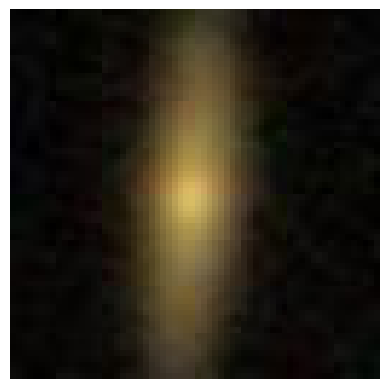

{'id': 1237649918429167747, 'ra': 15.689083, 'dec': 13.541472, 'spiral': 1, 'elliptical': 0}


In [9]:
#Let's see if we can plot any image

#We are openning the first TAR (for example)
tar_path = "Images/TAR-000000.tar"
with tarfile.open(tar_path, "r") as tar:
    # list contents
    members = tar.getmembers()
    # extract the first cutout
    img_member = members[0]
    img_bytes = tar.extractfile(img_member).read()

# show the image
img = Image.open(io.BytesIO(img_bytes)) 
plt.imshow(img)
plt.axis("off")
plt.show()

#print metadata of the first image of the tar file  
first_image_metadata = Images_metadata_csv[0]
print(first_image_metadata)